# Load .mat data

In [2]:
import h5py

mat_file = '../Files/220409181025_4997kLORs.mat'

file = h5py.File(mat_file, 'r')

# Print the keys of the file
print(list(file.keys()))
# Save the data from all keys
data = []
for key in file.keys():
    print(key)
    print(file[key])
    data.append(file[key])
# Access the data within the "/opt" group

EvtTime = data[1][()]
LORs = data[2][()]
RunName =data[3][()]
opt = data[4]



['#refs#', 'EvtTime', 'LORs', 'RunName', 'opt']
#refs#
<HDF5 group "/#refs#" (1 members)>
EvtTime
<HDF5 dataset "EvtTime": shape (1, 4997135), type "<f8">
LORs
<HDF5 dataset "LORs": shape (2, 3, 4997135), type "<f4">
RunName
<HDF5 dataset "RunName": shape (39, 1), type "<u2">
opt
<HDF5 group "/opt" (5 members)>


In [3]:
# print the opt group members
print(list(opt.keys()))
# Save the data from all keys
data = []
for key in opt.keys():
    print(key)
    print(opt[key])
    data.append(opt[key])

# acess the DPP data within the "/opt" group that is shape (6,1) type "<u2">
DPP = data[0][()]
print(DPP)

['DPP', 'DbStopBypass', 'LOR', 'allPlotsOff', 'saveLORs']
DPP
<HDF5 dataset "DPP": shape (6, 1), type "<u2">
DbStopBypass
<HDF5 dataset "DbStopBypass": shape (1, 1), type "|u1">
LOR
<HDF5 dataset "LOR": shape (6, 1), type "<u2">
allPlotsOff
<HDF5 dataset "allPlotsOff": shape (1, 1), type "|u1">
saveLORs
<HDF5 group "/opt/saveLORs" (1 members)>
[[126]
 [ 47]
 [ 68]
 [ 80]
 [ 80]
 [ 47]]


# Time Modifications

In [4]:
import datetime
import numpy as np

# Remove the extra dimension
time_full = np.squeeze(EvtTime)

# Convert the event time to a datetime object
time_datetime = [datetime.datetime.fromordinal(int(t)) + datetime.timedelta(days=t % 1) - datetime.timedelta(days=366) for t in time_full]

In [5]:
# The first and last date and the elapsed time
first_date_string = time_datetime[0].strftime('%d-%b-%Y %H:%M:%S')
last_date_string = time_datetime[-1].strftime('%d-%b-%Y %H:%M:%S')
elapsed_time = time_datetime[-1] - time_datetime[0]

print('Start time:   ', first_date_string)
print('End time:     ', last_date_string)
print('Elapsed time: ', elapsed_time)

# Time between first 100000 and last 100000 events
elapsed_first_100k = time_datetime[100000] - time_datetime[0]
elapsed_last_100k = time_datetime[-1] - time_datetime[-100000]

print('Time spent on the first 100k events:', elapsed_first_100k)
print('Time spent on the last 100k events: ', elapsed_last_100k)

Start time:    16-Mar-2022 21:58:45
End time:      17-Mar-2022 01:59:10
Elapsed time:  4:00:25.000002
Time spent on the first 100k events: 0:02:21
Time spent on the last 100k events:  0:20:58.000006


## Time difference

In [6]:
# Time diference between the first and each event
time_diff = [t - time_datetime[0] for t in time_datetime]

# Difference in seconds
time_diff_sec = [t.total_seconds() for t in time_diff]

# Difference in milliseconds
time_diff_msec = [t.total_seconds() * 1000 for t in time_diff]

# Histogram of data frequency

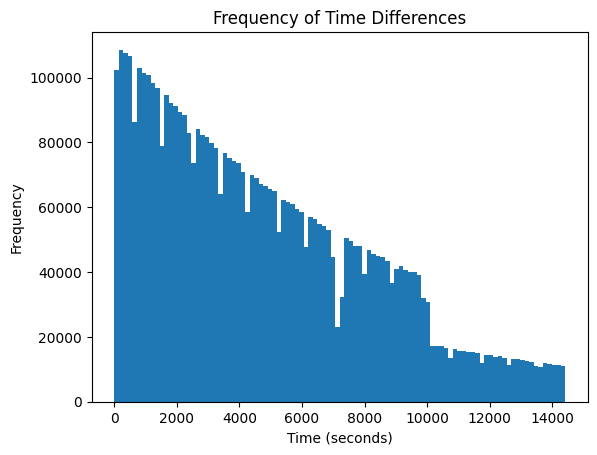

In [7]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Create a histogram
plt.hist(time_diff_sec, bins=100)

# Set the x-axis label
plt.xlabel('Time (seconds)')

# Set the y-axis label
plt.ylabel('Frequency')

# Set the title of the histogram
plt.title('Frequency of Time Differences')

# Display the histogram
plt.show()


## Fitting of exponential decay

In [8]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Define the exponential function
def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

# Define a function to calculate the sum of squared errors (SSE)
def calculate_sse(y_actual, y_predicted):
    # Convert the input lists to NumPy arrays for vectorized operations
    y_actual = np.array(y_actual)
    y_predicted = np.array(y_predicted)
    
    # Calculate squared errors and sum them up
    squared_errors = (y_actual - y_predicted) ** 2
    sse = np.sum(squared_errors)
    
    return sse

def fit_expon(x,y):
    
    # Perform the curve fit

    popt, pcov = curve_fit(exponential_decay, x, y, p0=[30600, 0.0001], maxfev=5000)

    # Extract the optimized parameters
    a_opt, b_opt = popt
    
    # Generate fitted values for plotting
    x_fit = np.linspace(min(x), max(x), 40)
    y_fit = exponential_decay(x_fit, a_opt, b_opt)
    
    # Calculate the predicted values of y using the fitted parameters
    y_predicted = exponential_decay(x, a_opt, b_opt)

    # Calculate R-squared (coefficient of determination)
    r2 = r2_score(y, y_predicted)
    
    # Calculate SSE
    sse = calculate_sse(y, y_predicted)
 
    # Calculate adjusted R-squared
    n = len(y)
    p = len(popt)
    adjusted_R_squared = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    return {'x': x_fit, 'y': y_fit, 'r2': r2, 'coefficients': popt, 'sse': sse,
            'adj_r2': adjusted_R_squared}

# Calculate the histogram values and bin edges
data = time_diff_sec
data = time_diff_sec[:int(len(time_diff_sec) * 2/3)]
hist, bin_edges = np.histogram(data, bins=100)

# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Fit the exponential decay function
fit_results = fit_expon(bin_centers, hist)

# Extract the decay constant
decay_constant = fit_results['coefficients'][1]

# Print the decay constant
print("Decay constant:", decay_constant)
print("Half-life:", np.log(2) / decay_constant/60, "minutes")
print("R-squared:", fit_results['r2'])
print("Adjusted R-squared:", fit_results['adj_r2'])
print("Sum of squared errors:", fit_results['sse'])

Decay constant: 0.00010544743661305671
Half-life: 109.55650872504921 minutes
R-squared: 0.7770543629721889
Adjusted R-squared: 0.7724575457138836
Sum of squared errors: 1051396695.2727562


## Plot the Exponential Decay curve

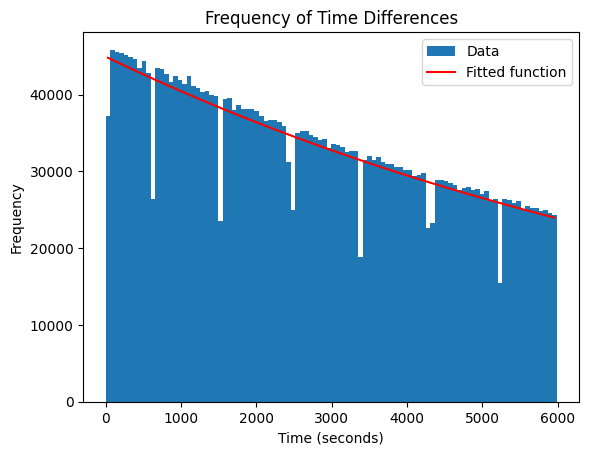

In [9]:
# Plot the histogram
plt.hist(data, bins=100, label='Data')
# Plot the fitted function
plt.plot(fit_results['x'], fit_results['y'], label='Fitted function', color='red')
# Set the x-axis label
plt.xlabel('Time (seconds)')
# Set the y-axis label
plt.ylabel('Frequency')
# Set the title of the histogram
plt.title('Frequency of Time Differences')
# Display the legend
plt.legend()
# Display the histogram
plt.show()


### Half-life calculation

In [11]:
print("Half-life:", np.log(2) / decay_constant/60, "minutes")

Half-life: 109.55650872504921 minutes


# Data Size and Shape

In [5]:
import numpy as np

[LORsX, LORsY, LORsZ] = [np.squeeze(LORs[:,i,:]) for i in [0,1,2]]
# Switch from (a,b) to (b,a)
[LORsX, LORsY, LORsZ] = [np.swapaxes(i, 0, 1)  for i in [LORsX, LORsY, LORsZ]]
# LORsX = np.swapaxes(LORsX, 0, 1)
print(LORsX.shape)

points = np.linspace(-1, 1, 100)
print(np.array([points, np.ones(points.size)]).shape)

(4997135, 2)
(2, 100)


In [6]:
# max(LORsZ[:,0])
max(LORs[0,2,:])

679.43176

In [7]:
indexs = np.random.choice(LORsX.shape[0], int(LORsX.shape[0]/10), replace=False)

# [LORX_small,LORY_small,LORZ_small] = [i[indexs] for i in [LORsX, LORsY, LORsZ]]
# print(LORX_small.shape)
# [LORX_points_small, LORY_points_small, LORZ_points_small]  = [i @ np.array([points, np.ones(points.size)]) for i in [LORX_small,LORY_small,LORZ_small]]
## OR
[LORX_points_small, LORY_points_small, LORZ_points_small]  = [i[indexs] @ np.array([points, np.ones(points.size)]) for i in [LORsX, LORsY, LORsZ]]
print(LORX_points_small.shape)

(499713, 100)


In [8]:
LOR3D_points_small = np.array([LORX_points_small, LORY_points_small, LORZ_points_small])
LOR2D_points_small = np.array([LORX_points_small, LORY_points_small])
print('Shape of LOR3D_points_small:', LOR3D_points_small.shape)
print('Shape of LOR2D_points_small:', LOR2D_points_small.shape)


Shape of LOR3D_points_small: (3, 499713, 100)
Shape of LOR2D_points_small: (2, 499713, 100)


In [9]:
LOR3D_points_small_endpoints = np.array([LOR3D_points_small[:,:,0], LOR3D_points_small[:,:,-1]])
LOR2D_points_small_endpoints = np.array([LOR2D_points_small[:,:,0], LOR2D_points_small[:,:,-1]])
print('Shape of LORs_points_small_endpoints:', LOR3D_points_small_endpoints.shape)
print('Shape of LOR2D_points_small_endpoints:', LOR2D_points_small_endpoints.shape)


Shape of LORs_points_small_endpoints: (2, 3, 499713)
Shape of LOR2D_points_small_endpoints: (2, 2, 499713)
